# Remarks:

- Save your adjacency matrix with an evident name in the sub folder "<b><i>./Data/Adjacencies/</i></b>" and update list next cell.
- Only overwrite these if you're sure of what you're bringing
- If you change Imports, make sure the rest works
- Please check your results



### Adjacencies available:
- **adjacency_hyperlinks**: constructed with every category and links based on hyperlinks. **This is directed and it is normal!** If you need it otherwise, symmetrise it and save it in another csv. 


### Useful functions:

From Task 1:
- sparsify_adjacency(adjacency, All_Nodes, epsilon, seed): sparsify the adjacency matrix and also returns the list of nodes in it and their categories.

- assign_values(All_Nodes, assign_val): assign a value to each category based on assign_val. First entry for 'player', second for 'Country' and last for 'National Team'.



## Install

...

# Imports:

In [54]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy
from operator import itemgetter
import collections
import scipy as sc

from sklearn.manifold import spectral_embedding

from pygsp import graphs, filters, reduction, plotting, utils
from scipy import sparse

from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

%matplotlib inline

# Part I
# Structure of the Graph with Hyperlink Connections between sites

## Import Data

In [4]:
Nodes_Linked = pd.read_csv("./Data/Nodes_Linked.csv", sep='\t', encoding= 'utf-16')
All_Nodes = pd.read_csv("./Data/All_Nodes.csv", sep='\t', encoding= 'utf-16')

## Make Adjacency (great again)

<b>If you are not going to change it, you can skip this and load it.</b>

In [5]:
All_Nodes.reset_index(level=0, inplace=True)
All_Nodes = All_Nodes.rename(columns={'index':'node_idx'})


# Create a conversion table from name to node index.
name2idx = All_Nodes[['node_idx', 'Node']]
name2idx = name2idx.set_index('Node')

Nodes_Linked = Nodes_Linked.join(name2idx, on='Nodes')
Nodes_Linked = Nodes_Linked.join(name2idx, on='Links', rsuffix='_target')
Nodes_Linked_Full = Nodes_Linked.copy(deep=True)
Nodes_Linked = Nodes_Linked.drop(columns=['Nodes', 'Links', 'Node_Category'])
Nodes_Linked['node_idx'] = Nodes_Linked['node_idx'].astype(int)
Nodes_Linked['node_idx_target'] = Nodes_Linked['node_idx_target'].astype(int)

<b>Check if any value is Nan!</b>

In [6]:
Nodes_Linked.isnull().any().any()

False

<b>Great! Now build the Adjacency Matrix</b>:

In [7]:
n_nodes = len(All_Nodes)
print("Number of nodes ", n_nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in Nodes_Linked.iterrows():
    if np.isnan(row.node_idx_target):
        continue
    i, j = int(row.node_idx), int(row.node_idx_target)
    adjacency[i, j] = 1


Number of nodes  800


<b>Set Diagonal to 0</b>:

In [8]:
Sum = 0
for i in range(n_nodes):
    Sum += adjacency[i,i]
    adjacency[i,i] = 0
print("Sum of values on the diagonal was " +str(Sum)+". Now it's 0.")

Sum of values on the diagonal was 57. Now it's 0.


**Display:**

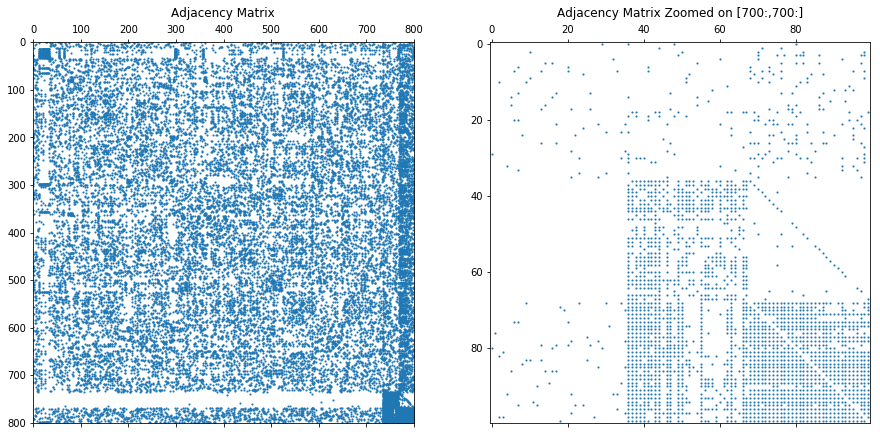

Diagonal on the right? Example adjacency(760, 792) = 1. Corresponds to link (Serbia,Serbia national football team).


In [9]:
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.spy(adjacency, markersize=1)
ax1.set_title('Adjacency Matrix')
ax2= fig.add_subplot(1,2,2)
ax2.spy(adjacency[700:, 700:], markersize=1)
ax2.set_title('Adjacency Matrix Zoomed on [700:,700:]')

plt.show()

print("Diagonal on the right? Example adjacency(760, 792) = " + str(adjacency[760, 792]) +\
      ". Corresponds to link (" + str(All_Nodes.iloc[760,1])+"," + str(All_Nodes.iloc[792,1])+").")

We can clearly observe that the first 732 entries are players, connecting to about anything. They are then followed by the 32 countries taking part in the world cup, only connecting themselves and their respective national teams (though some other teams may appear in their sport history due to some notable event. This is the case for Iceland for example, as can be seen below). Finally, the national teams connect to everyone (and themselves heavily, since the history of matches maps this).

In [225]:
Nodes_Linked_Full.iloc[[24642, 24643, 24651], :]

,Nodes,Links,Node_Category,node_idx,node_idx_target
24642,Iceland,Iceland national football team,Country,753,785
24643,Iceland,France national football team,Country,753,775
24651,Iceland,England national football team,Country,753,779


## Save the Adjacency

In [ ]:
if (0):
    df_adjacency = pd.DataFrame(adjacency)
    df_adjacency.to_csv('./Data/Adjacencies/adjacency_hyperlinks.csv', index=False)

## Let's make the matrix sparse and display the graph associated

Check that it is indeed connected. 

In [56]:
adjacency = pd.read_csv("./Data/Adjacencies/adjacency_hyperlinks.csv").values

In [57]:
adjacency_sparsed = sparse.csr_matrix(adjacency)

800 nodes, 27532 edges
Connected: True
Directed: True


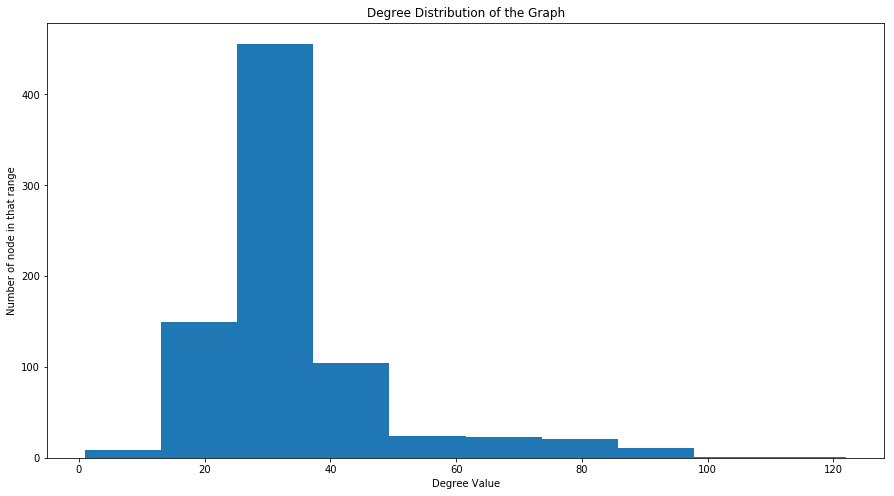

In [217]:
G = graphs.Graph(adjacency_sparsed)
print('{} nodes, {} edges'.format(G.N, G.Ne))

print('Connected: {}'.format(G.is_connected()))
print('Directed: {}'.format(G.is_directed()))
fig = plt.figure(figsize = (15,8))
plt.hist(G.d)
plt.title('Degree Distribution of the Graph')
plt.xlabel('Degree Value')
plt.ylabel('Number of node in that range')
plt.show()

#print("Maximum of " +str(G.d[783])+ " corresponds to " + str(All_Nodes.iloc[783, 1]) +".")

So we do have a connected and directed graph. Note that the average number of connection is quite high (27532/800 = 34.42)! The extremum of 122 corresponds to the Croatian national football team (https://en.wikipedia.org/wiki/Croatia_national_football_team) which has an amazingly complete page.

The next plot of the graph takes a good while. 

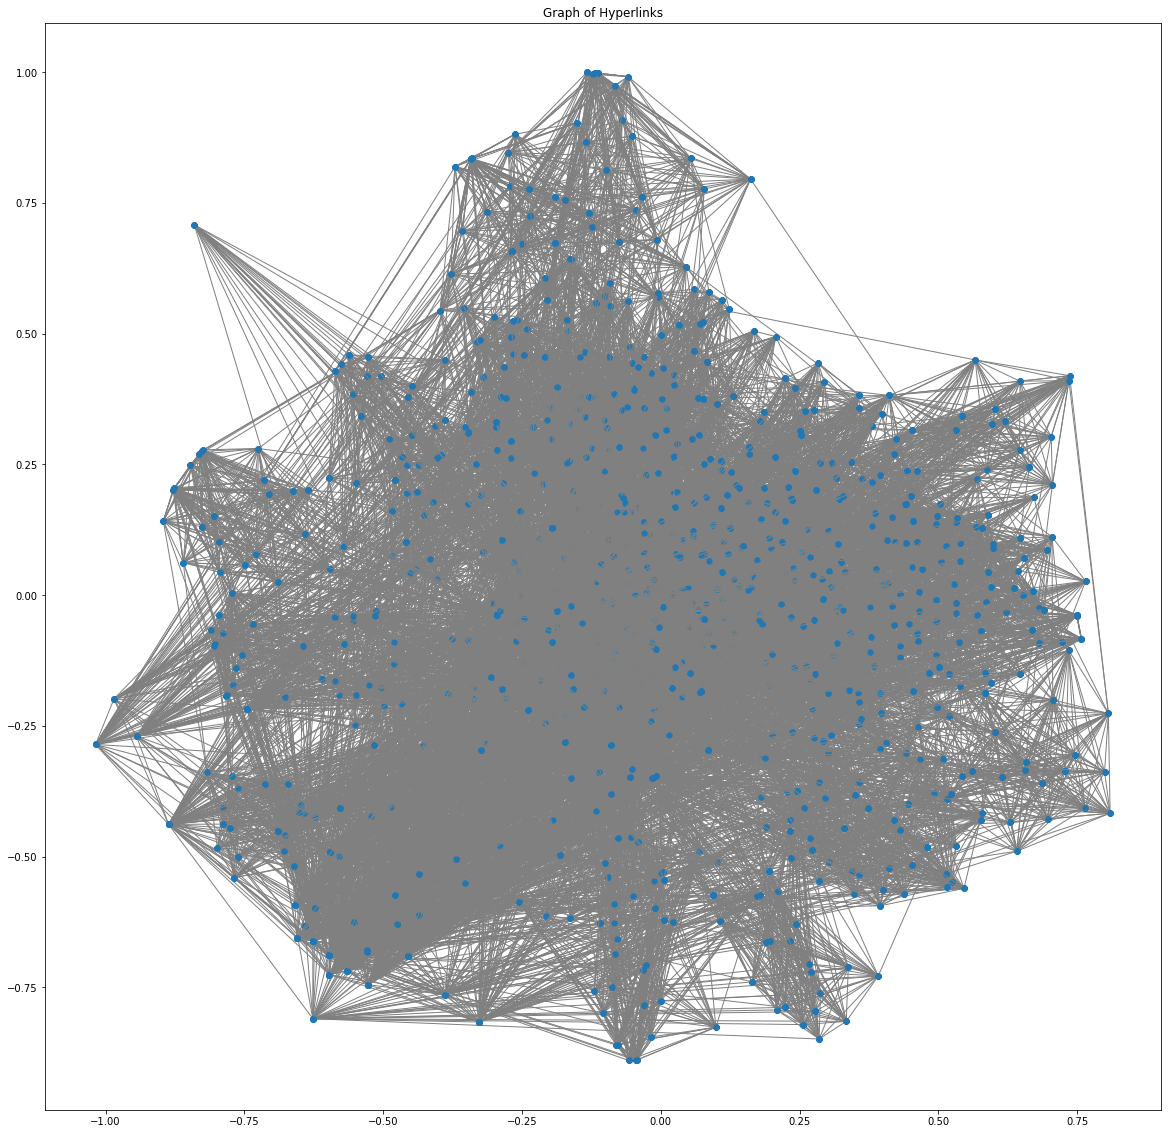

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
G.set_coordinates()
G.plot(backend= 'matplotlib', plot_name = 'Graph of Hyperlinks',\
    show_edges = 'True',vertex_size =50, ax = ax, save_as="png")
if(0):
    plt.savefig('./Images/TASK1_Graph_Hyperlinks.png')
plt.show()

This is quite naturally very dense and hard to read. To observe the structure, let's <b>get a sparsified version of this graph</b> as governed by the parameter _epsilon_.

In [8]:
epsilon = 0.4
seed = 9087   #To have same results

The following sparsifies thanks to PYGSP but doesn't indicate which nodes are left so useless here: G_Sparsified = reduction.graph_sparsify(G, epsilon)

We rather write a function doing this (note that the seed will be fixed):

In [9]:
def sparsify_adjacency(adjacency, All_Nodes, epsilon, seed):
    """
    Returns the sparsified adjacency as well as the list of nodes in it (with their categories)
    """
    nodes_local = All_Nodes.copy(deep=True)
    adjacency_local = copy.deepcopy(adjacency)
    
    n_nodes_initial = adjacency.shape[0]
    n_nodes_final = round(n_nodes_initial*epsilon)
    n_nodes_deleted= n_nodes_initial - n_nodes_final
    print("Will end up with "+ str(n_nodes_final)+ " nodes.")
    
    np.random.seed(seed)
    nodes_to_delete = np.random.choice(n_nodes_initial, n_nodes_deleted,replace=False)
    
    #Remove selected rows(and columns)
    adjacency_local = np.delete(adjacency_local, nodes_to_delete, axis=0)        
    adjacency_local = np.delete(adjacency_local, nodes_to_delete, axis=1)
    
    #Remove these from the list of nodes and their categories
    nodes_local = nodes_local.drop(nodes_local.index[nodes_to_delete])

    return adjacency_local, nodes_local


In [10]:
adjacency_sparsified, Nodes_Sparsified = sparsify_adjacency(adjacency, All_Nodes, 0.4, seed)

Will end up with 320 nodes.


To plot the signal, we will assign a value to each category from the list assign_val (first elem for players, second countries and last national teams). The next function applies this by creating a <b>new column <i>Category_bin</i></b> in a new dataframe.

In [11]:
def assign_values(All_Nodes, assign_val):
    nodes_local = All_Nodes.copy(deep=True)
    nodes_local['Category_bin'] = ''
    size = nodes_local.shape[0]
    for i in range(size):
        cat = nodes_local.iloc[i, 1]
        if(cat == 'player'):
            nodes_local.iloc[i, 2] = assign_val[0]
        if(cat == 'Country'):
            nodes_local.iloc[i, 2] = assign_val[1]
        if(cat == 'National Team'):
            nodes_local.iloc[i, 2] = assign_val[2]
    return nodes_local

In [12]:
Nodes_Sparsified_binned = assign_values(Nodes_Sparsified, [0, 5, 10])

In [13]:
adjacency_sparsified_sparsed = sparse.csr_matrix(adjacency_sparsified)
signal_category = Nodes_Sparsified_binned['Category_bin'].values

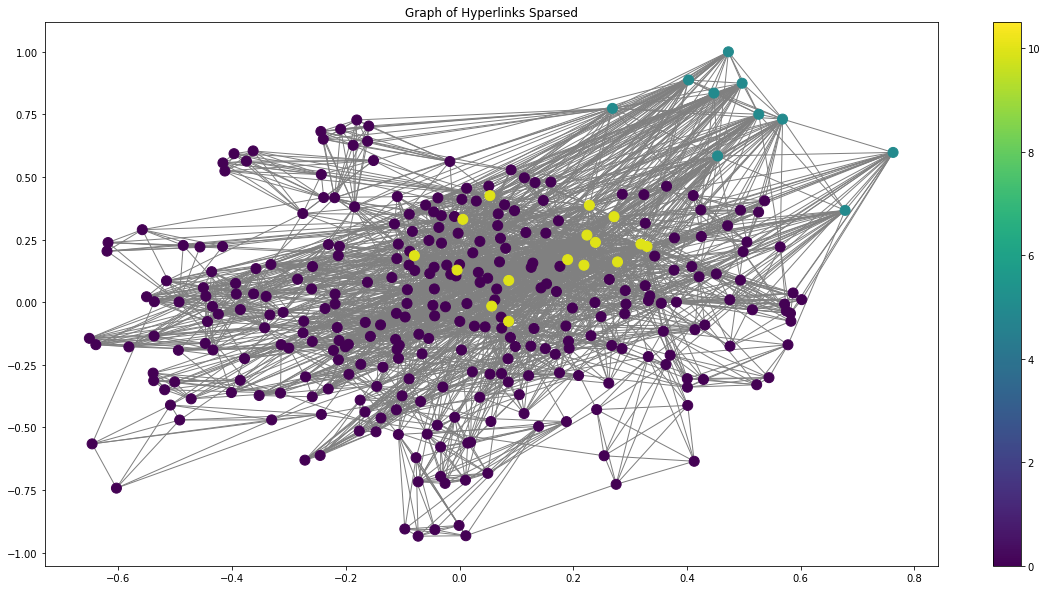

In [14]:
G_Sparsified = graphs.Graph(adjacency_sparsified_sparsed)
fig, ax = plt.subplots(figsize=(20, 10))
G_Sparsified.set_coordinates()
plotting.plot_signal(G_Sparsified, signal_category, backend= 'matplotlib',ax = ax, \
                     plot_name = 'Graph of Hyperlinks Sparsed', vertex_size =100)
if(0):
    plt.savefig('./Images/TASK1_Graph_Hyperlinks_Sparsified.png')
plt.show()

What a wonderful mess! A structure is quite visible. In yellow, one finds the _National Teams_. These are quite visibly at the heart of the network : both connecting _Players_ (purple) and the _Countries_ (blue). Note how the countries form a connected set on the left. 

#### Let's observe the degree distribution seperately for each category. 

We take back our full system. Remember there are 736 players, 32 countries and 32 teams and that they appear in that order in the adjacency.

In [15]:
degree_dist_player_part = G.d[0:736]
degree_dist_countries_part = G.d[736:768]
degree_dist_teams_part = G.d[768:800]

In [16]:
adjacency_sparsed_transpose = adjacency_sparsed.T
G_T = graphs.Graph(adjacency_sparsed_transpose)

arrival_dist_player_part = G_T.d[0:736]
arrival_dist_countries_part = G_T.d[736:768]
arrival_dist_teams_part = G_T.d[768:800]

First line: Degree Distributions 
Second line: Arrival distribution


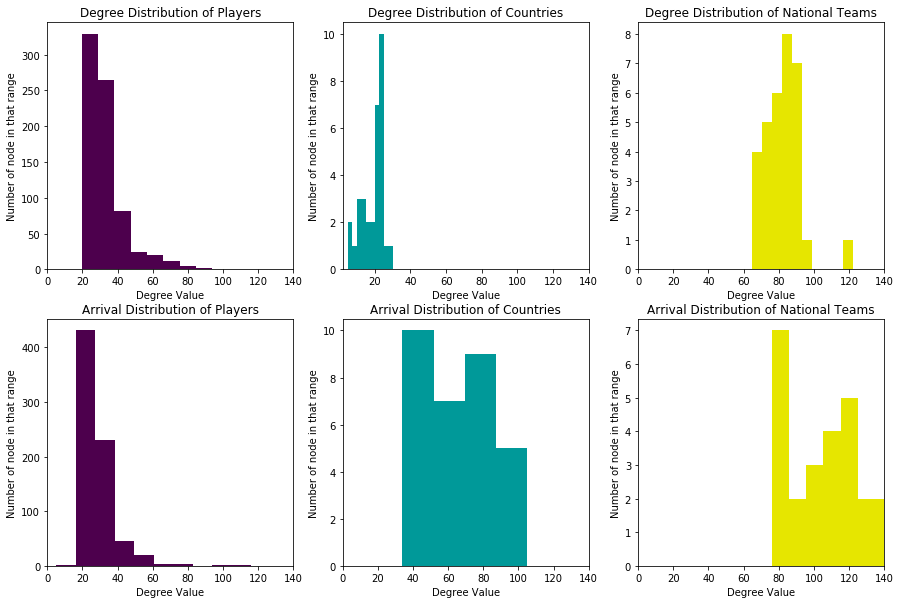

In [17]:
print("First line: Degree Distributions \nSecond line: Arrival distribution")
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,3,1)
ax1.hist(degree_dist_player_part, color = '#4d004d')
ax1.set_title('Degree Distribution of Players')
ax1.set_xlabel('Degree Value')
ax1.set_ylabel('Number of node in that range')
ax1.set_xlim(0, 140)

ax2 = fig.add_subplot(2,3,2)
ax2.hist(degree_dist_countries_part, color = '#009999')
ax2.set_title('Degree Distribution of Countries')
ax2.set_xlabel('Degree Value')
ax2.set_ylabel('Number of node in that range')
ax2.set_xlim(2, 140)

ax3 = fig.add_subplot(2,3,3)
ax3.hist(degree_dist_teams_part, color = '#e6e600')
ax3.set_title('Degree Distribution of National Teams')
ax3.set_xlabel('Degree Value')
ax3.set_ylabel('Number of node in that range')
ax3.set_xlim(0, 140)

ax4 = fig.add_subplot(2,3,4)
ax4.hist(arrival_dist_player_part, color = '#4d004d')
ax4.set_title('Arrival Distribution of Players')
ax4.set_xlabel('Degree Value')
ax4.set_ylabel('Number of node in that range')
ax4.set_xlim(0, 140)

ax5 = fig.add_subplot(2,3,5)
ax5.hist(arrival_dist_countries_part, color = '#009999')
ax5.set_title('Arrival Distribution of Countries')
ax5.set_xlabel('Degree Value')
ax5.set_ylabel('Number of node in that range')
ax5.set_xlim(0, 140)

ax6 = fig.add_subplot(2,3,6)
ax6.hist(arrival_dist_teams_part, color = '#e6e600')
ax6.set_title('Arrival Distribution of National Teams')
ax6.set_xlabel('Degree Value')
ax6.set_ylabel('Number of node in that range')
ax6.set_xlim(0, 140)

if(0):
    plt.savefig('./Images/TASK1_Degree_Distributions.png')


plt.show()


Clearly, these different categories of node do not exhibit the same behaviour. <b>_Countries_</b> connect very poorly to the rest of the nodes. They are however a regular target destination as one can observe on the second row. This is quite natural: most players and national teams point to their own country but a player must have had some impressive achievements to be referenced in the Wikipedia page of a country.

<b>_Players_</b> have an intermediary behaviour, some being heavily connected (surely famous players<b>*</b>) but most averaging around 30 connections. They tend to be rarelier a target which matches our intuition: it's unlikelier for a country to point to a certain player than vice versa. Also, only famous players are likely to be a target for other players.

Finally, <b>_National Teams_</b> are the most intensely connected since they link most of their players, some of the other national teams (due, for example, to matches history on the Wikipedia page) and their country. They clearly <b>are the hubs of our network</b>. Note how, as we saw earlier, Croatia's National Football team appears as an outlier on the 120 centred-bin. 

<b>*</b> For example, players having more than 80 as a degree value have node labels : [300, 455, 470, 506]. These corresponds to:

In [18]:
All_Nodes.iloc[[300, 455, 470, 506], :]

,Node,Category
300,Eden Hazard,player
455,Lionel Messi,player
470,Luka Modrić,player
506,Neymar,player


<b>So yes, quite famous players.</b>

## On this bombshell, this first part concludes. 

# Part 2

### Expansion of Analysis

- General Analysis
- clustering (Louvain Method)

## General Analysis

First of all, let's create a new adjacency matrix with names and attributes attached to it. For that we create nodes and edges frames.

Now that we have edges and nodes dataframe, we can create a network setting category as an attribute:

In [75]:
def create_nodes_egdes():

    edges = Nodes_Linked_Full.drop(columns=['Node_Category', 'node_idx', 'node_idx_target'])
    
    nodes = All_Nodes.copy(deep=True)
    nodes.set_index('Node', inplace=True)

    df_obj = edges.select_dtypes(['object'])
    edges[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    df_obj = All_Nodes.select_dtypes(['object'])
    All_Nodes[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    display(Nodes_Linked_Full.head())
    display(All_Nodes.head())
    
    return nodes, edges

nodes, edges = create_nodes_egdes()
edges.shape

,Nodes,Links,Node_Category,node_idx,node_idx_target
0,Mohamed Abdel-Shafy,Saad Samir,player,0,608
1,Mohamed Abdel-Shafy,Ali Gabr,player,0,239
2,Mohamed Abdel-Shafy,Egypt,player,0,757
3,Mohamed Abdel-Shafy,Motaz Hawsawi,player,0,297
4,Mohamed Abdel-Shafy,Amr Warda,player,0,715


,node_idx,Node,Category
0,0,Mohamed Abdel-Shafy,player
1,1,Shehu Abdullahi,player
2,2,Amir Abedzadeh,player
3,3,Johnny Acosta,player
4,4,Marcos Acuña,player


(27589, 2)

In [76]:
#directed
G_n = nx.from_pandas_edgelist(edges, 'Nodes', 'Links', edge_attr=None, create_using= nx.DiGraph())
nx.set_node_attributes(G_n, nodes['Category'].to_dict(), 'Category')

#observe an example
G_n.node['Lionel Messi']

{'Category': 'player'}

In [77]:
#undirected version of our directed Graph
G_s = nx.from_pandas_edgelist(edges, 'Nodes', 'Links', edge_attr=None, create_using= nx.Graph())
nx.set_node_attributes(G_n, nodes['Category'].to_dict(), 'Category')

print(nx.info(G_s))

Name: 
Type: Graph
Number of nodes: 800
Number of edges: 15950
Average degree:  39.8750


In [78]:
print(nx.info(G_n))

Name: 
Type: DiGraph
Number of nodes: 800
Number of edges: 27589
Average in degree:  34.4862
Average out degree:  34.4862


As indicated above, our network consists of 800 nodes (articles corresponding to world cup players/countries/national teams) and there are 15893 edges (hyperlinks) between them. Furthermore, average degree is given as around 40, suggesting sparsity of our network. However, for better estimate let's compute $ S = \frac{|E|}{|E_{max}|}$

In [79]:
print("Network sparsity: %.4f" %nx.density(G_n))

Network sparsity: 0.0432


Therefore, we have a sparse graph.

As we already examined in the previous section, we have a connected graph. Therefore, our network corresponds to the one giant connected component with 800 nodes. Further, let's estimate longest shortest path between any two nodes to better understand our settings:

In [80]:
diameter = nx.diameter(G_n)
print("The diameter of the component is", diameter)

The diameter of the component is 5


Considering sparsity of our network combined with the diameter quantified as 5, we conclude that we observe small world problem. Meaning that even though two random nodes in our network are unlikely to be connected, they path betweem is short, in our case 5 on average.

Furthermore, let's examine <b>transitivity</b> (ratio of all existing triangles over all possible triangles) of our network:

In [81]:
print('%.3f'%nx.transitivity(G_n))

0.508


In [82]:
# We have a similar measure but for individual nodes called clustering coefficient
print(nx.clustering(G_n, ['Ali Gabr', 'Lionel Messi']))

{'Ali Gabr': 0.9429864253393665, 'Lionel Messi': 0.2238109756097561}


In [83]:
# Lets check by looking at the subgraphs induced by Messi and Ali
subgraph_Christian = G_n.subgraph(['Hong Chul'] + list(G_n.successors('Hong Chul')))
subgraph_Messi = G_n.subgraph(['Lionel Messi'] + list(G_n.neighbors('Lionel Messi')))

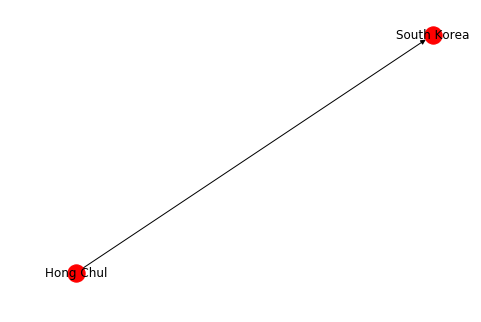

In [84]:
nx.draw_spring(subgraph_Christian, with_labels=True)

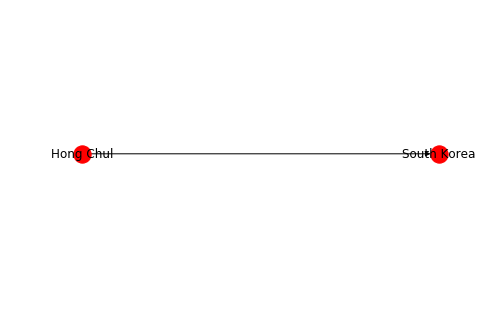

In [85]:
nx.draw_circular(subgraph_Christian, with_labels=True)

Furthermore, let's have a look at a degree distribution:

Text(0.5,1,'Degree distribution for the World Cup network')

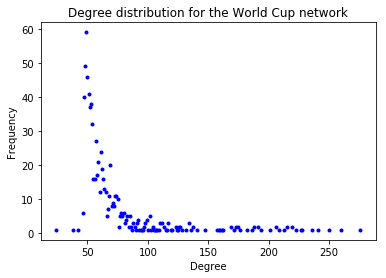

In [89]:
degrees = dict(G_n.degree(G_n.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markeredgecolor='none', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the World Cup network')

As we can see degree distribution resembels scale-free network with few centralized hubs.

Which player/participant country/national team is more "important" as measured by their degree:

In [90]:
# And the top 5 most popular players are.. 
for nodes, degree in sorted_degree[:5]:
    print(nodes, ' who is', G_n.node[nodes]['Category'], 'connects to', degree, 'nodes')

Croatia national football team  who is National Team connects to 276 nodes
France national football team  who is National Team connects to 260 nodes
England national football team  who is National Team connects to 250 nodes
Portugal national football team  who is National Team connects to 241 nodes
Russia  who is Country connects to 236 nodes


As we see, the most important nodes are represented by national teams, however if we restrict nodes to players only, we get:

In [91]:
player_nodes = [x for x,y in G_n.nodes(data=True) if y['Category']=='player']
player_Graph = G_n.subgraph(player_nodes)

degrees = dict(player_Graph.degree(player_Graph.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular nodes are.. 
for nodes, degree in sorted_degree[:5]:
    print(nodes, ' who is', G_n.node[nodes]['Category'], 'connects to', degree, 'nodes')

Lionel Messi  who is player connects to 157 nodes
Eden Hazard  who is player connects to 149 nodes
Cristiano Ronaldo  who is player connects to 145 nodes
Luis Suárez  who is player connects to 140 nodes
Neymar  who is player connects to 127 nodes


As we can see degree distribution appeared to be valid metric of importance/popularty of players. The top results correspond to one of the most popular/influential/discussed footballers.

Another approach of determining "importance" is to examine number of shortest paths passing though a node. The bigger the number the higher the importance of the node (<b>betweeness centrality</b>):

In [92]:
betweenness = nx.betweenness_centrality(G_n) # Run betweenness centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G_n, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for node, bw in sorted_betweenness[:5]:
    print(node, ' who/that is', G_n.node[node]['Category'], 'has betweeness: %.3f' %bw)

South Korea national football team  who/that is National Team has betweeness: 0.043
Panama national football team  who/that is National Team has betweeness: 0.041
Croatia national football team  who/that is National Team has betweeness: 0.040
Saudi Arabia national football team  who/that is National Team has betweeness: 0.039
Costa Rica national football team  who/that is National Team has betweeness: 0.039


Here again, let's estimate betweenness for players subgraph only.

In [93]:
betweenness = nx.betweenness_centrality(player_Graph) # Run betweenness centrality

# Assign each to an attribute in your network
nx.set_node_attributes(player_Graph, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for node, bw in sorted_betweenness[:5]:
    print(node, ' who/that is', G_n.node[node]['Category'], 'has betweeness: %.3f' %bw)

Keylor Navas  who/that is player has betweeness: 0.053
Luis Suárez  who/that is player has betweeness: 0.052
Lionel Messi  who/that is player has betweeness: 0.046
Mohamed Salah  who/that is player has betweeness: 0.046
Son Heung-min  who/that is player has betweeness: 0.034


As we see, even though countries list looks different compared to importance measured by degree distribution in case of players we clearly have dominant players such as Lionel Messi and Luis Suarez.

Let's visualize values of betweenness of the whole network for a better insight.

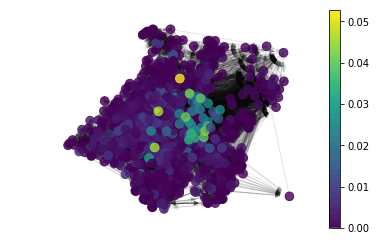

In [94]:
# similar pattern
list_nodes =list(G_n.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(G_n)
ec = nx.draw_networkx_edges(G_n, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G_n, pos, nodelist=list_nodes, node_color=[G_n.nodes[n]["betweenness"] for n in list_nodes], 
                            with_labels=False, alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

As we can see most of the nodes have a very low betweeness centrality with just few of them above 0.03.

## Community Detection

We will try to detect comunities using Lovain method. The algorithm is iterative. It starts considering every node as a different cluster. Afterwards, communities are traversed and tested if joining it with neighbouring cluster yields a better results.

In [95]:
partition = community_louvain.best_partition(G_s)
# add it as an attribute to the node
for n in G_n.nodes:
    G_n.nodes[n]["louvain"] = partition[n]

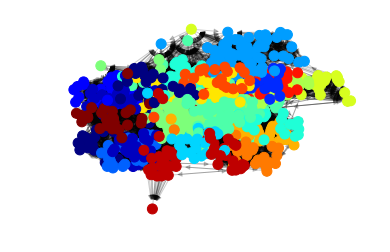

In [96]:
# plot it out
pos = nx.spring_layout(G_n,k=0.2)
ec = nx.draw_networkx_edges(G_n, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G_n, pos, nodelist=G_n.nodes(), node_color=[G_n.nodes[n]["louvain"] for n in G_n.nodes], 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's have a closer look at clusters, but before let's add aditional information to nodes corresponding to the players, such as their football team and position.

In [97]:
#dataset of players with their corresponding teams
player_team = pd.read_csv("./Data/Team_Players.csv")
player_team.set_index('Players', inplace=True)

#trim strings
df_obj = player_team.select_dtypes(['object'])
player_team[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

display(player_team.head())

#adding to our graph as attributes
nx.set_node_attributes(G_n, player_team['Team'].to_dict(), 'Team')

,Team,Position,Captain
Players,,,
Essam El-Hadary,Egypt national football team,GK,1
Ali Gabr,Egypt national football team,DF,0
Ahmed Elmohamady,Egypt national football team,DF,0
Omar Gaber,Egypt national football team,MF,0
Sam Morsy,Egypt national football team,MF,0


In [110]:
cluster_iceland = partition['Sverrir Ingi Ingason']
members_c = [q for q in G_n.nodes if partition[q] == cluster_iceland]
# get info about these players
for node in members_c:
    str = ""
    if G_n.node[node]['Category'] == 'player' and 'Team' in G_n.node[node]:
        str = "in %s"%G_n.node[node]['Team']
        
    print(node, ' who/that is', G_n.node[node]['Category'], str)

Iceland national football team  who/that is National Team 
Hörður Björgvin Magnússon  who/that is player in Iceland national football team
Kári Árnason  who/that is player in Iceland national football team
Arnór Ingvi Traustason  who/that is player in Iceland national football team
Alfreð Finnbogason  who/that is player in Iceland national football team
Rúnar Alex Rúnarsson  who/that is player in Iceland national football team
Albert Guðmundsson (footballer, born 1997)  who/that is player 
Ragnar Sigurðsson  who/that is player in Iceland national football team
Jón Daði Böðvarsson  who/that is player in Iceland national football team
Aron Gunnarsson  who/that is player in Iceland national football team
Rúrik Gíslason  who/that is player in Iceland national football team
Björn Bergmann Sigurðarson  who/that is player in Iceland national football team
Ari Freyr Skúlason  who/that is player in Iceland national football team
Jóhann Berg Guðmundsson  who/that is player in Iceland national fo

As we see even though players of the same team are clustered together, in some clusters several teams are combined together. Let's check if players of the same team are also assigned to the same cluster. Also, let's identify clustering of each country.

In [132]:
#create a dictionary pairing teams with their corresponding clusters
cluster_dic = {}

In [137]:
#number of players that have been clustered to cluster other than their team members
counter = 0

for x,y in G_n.nodes(data=True):
    #print(y)
    if y['Category'] == 'player':
        if 'Team' in y:
            team = y['Team']
            
            #if mapping from team to cluster exists, check if it is followed by this player as well
            if team in cluster_dic:
                if cluster_dic[team] != y['louvain']:
                    counter = counter + 1
                    
            #if mapping from team to cluster does not exist, add
            if team not in cluster_dic:
                cluster_dic[team] = y['louvain']
        
print("Number of Players classified in cluster other than one of their teammembers: %d"%counter)

Number of Players classified in cluster other than one of their teammembers: 0


In [138]:
#cluster assignement of teams
cluster_dic

{'Egypt national football team': 0,
 'Saudi Arabia national football team': 1,
 'Nigeria national football team': 2,
 'Iran national football team': 4,
 'Costa Rica national football team': 5,
 'Argentina national football team': 8,
 'Uruguay national football team': 8,
 'Peru national football team': 11,
 'Germany national football team': 8,
 'Colombia national football team': 10,
 'England national football team': 9,
 'Spain national football team': 12,
 'France national football team': 9,
 'Portugal national football team': 8,
 'Brazil national football team': 9,
 'Belgium national football team': 9,
 'Denmark national football team': 15,
 'Serbia national football team': 6,
 'Morocco national football team': 16,
 'Croatia national football team': 12,
 'Poland national football team': 7,
 'Switzerland national football team': 7,
 'Japan national football team': 17,
 'Russia national football team': 3,
 'Iceland national football team': 13,
 'South Korea national football team': 17,
